# Intro to Autoencoders

This tutorial introduces autoencoders

An autoencoder is a special type of neural network that is trained to copy its input to its output. For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error.

## Import TensorFlow and other libraries

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.datasets import fashion_mnist

## Load the dataset
To start, you will train the basic autoencoder using the Fashion MNIST dataset. Each image in this dataset is 28x28 pixels.

In [29]:
(x_train, _), (x_test, _) = fashion_mnist.load_data() #load data

x_train = x_train.astype('float32') / 255. #normalize
x_test = x_test.astype('float32') / 255.

## Looking at the Data

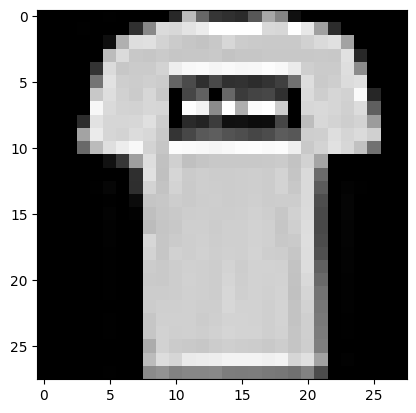

In [28]:
#plot one of the images
image_nr = 1
plt.imshow(x_train[image_nr], cmap='gray', vmin=0, vmax=1)
plt.show()

## Basic autoencoder

Define an autoencoder with two Dense layers: an `encoder`, which compresses the images into a 64 dimensional latent vector, and a `decoder`, that reconstructs the original image from the latent space.

In [ ]:
'''
First step is to intilize the autoencoder
'''

## Define the encoder
N_HIDDEN = 64 # Dimension which the Encoder reduces the image to
ACTIVATION_FUNCTION_ENCODER = 'relu'

encoder = models.Sequential()
# add one dense hidden layer to the encoder, with the input size 784 (784 pixels) and the output size 64
encoder.add(Dense(N_HIDDEN, input_shape=(784,)))
encoder.add(Activation(ACTIVATION_FUNCTION_ENCODER))

# Define the decoder
ACTIVATION_FUNCTION_DECODER = 'sigmoid'
decoder = models.Sequential()
# add one output layer to the decoder, with the input size 64 (hidden layer of the encoder) and the output size 784
decoder.add(Dense(784))
decoder.add(Activation(ACTIVATION_FUNCTION_DECODER))

# Define the autoencoder model
input_img = tf.keras.Input(shape=(784,)) #Generic input
encoded = encoder(input_img) #encoder input
decoded = decoder(encoded)  #decoder input

autoencoder = tf.keras.Model(input_img, decoded) #autoencoder: takes input_img and returns decoded picture

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse') #adam: type of optimizer used to minimize the loss function. mse: loss function. difference between input and output

c:\Users\lklei\anaconda3\envs\Tensorflow\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
'Now we train the autoencoder'
# reshape the data so that the autoencoder can uderstand it
x_train = x_train.reshape(60000, 784) 
x_test = x_test.reshape(10000, 784) 

print (x_train.shape)

# The autoencoder fits the data to the data -> in the end nothing should change
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=32,
                shuffle=True, 
                validation_data=(x_test, x_test)) # shuffle the data after each epoch to reduce overfitting, 


(60000, 784)
Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 960us/step - loss: 0.0345 - val_loss: 0.0143
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 892us/step - loss: 0.0140 - val_loss: 0.0133
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 907us/step - loss: 0.0132 - val_loss: 0.0132
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 931us/step - loss: 0.0130 - val_loss: 0.0140
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 885us/step - loss: 0.0127 - val_loss: 0.0125
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 861us/step - loss: 0.0124 - val_loss: 0.0123
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 862us/step - loss: 0.0123 - val_loss: 0.0122
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 885us/step - loss: 0.0122 - val_loss: 0.0121
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 869us/step - loss: 0.0121 - val_loss: 0.0121
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 862us/step - loss: 0.0121 - val_loss: 0.0121


Now that the model is trained, let's test it by encoding and decoding images from the test set.

In [ ]:
# Use the encoder and decoder models directly since they're defined separately
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# Make sure your reshape matches the test set size (10000, not 60000)
decoded_imgs = decoded_imgs.reshape(-1, 28, 28)  # Using -1 to automatically determine the first dimension
print(decoded_imgs.shape)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step
(10000, 28, 28)


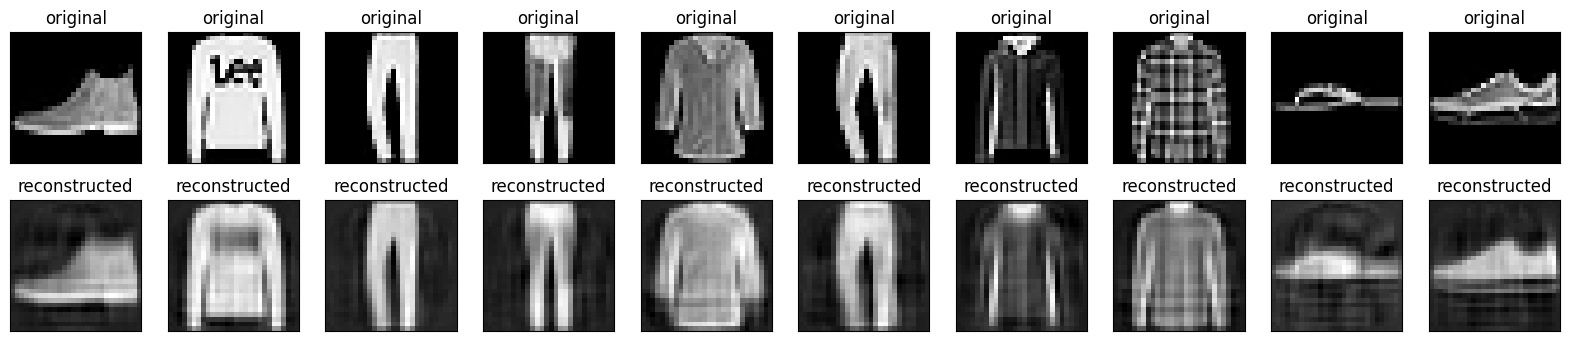

In [ ]:
n = 10
plt.figure(figsize=(20, 4)) # 20 subplots are created
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test.reshape(-1, 28, 28)[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()